In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

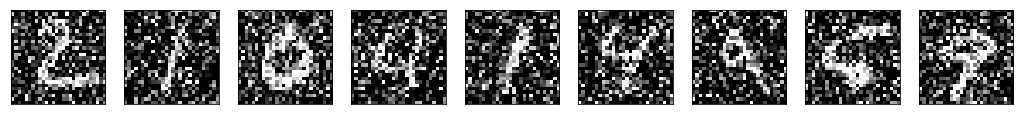

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 125us/step - loss: 0.1788 - val_loss: 0.1263
Epoch 2/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1195 - val_loss: 0.1147
Epoch 3/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1115 - val_loss: 0.1069
Epoch 4/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.1077 - val_loss: 0.1083
Epoch 5/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1053 - val_loss: 0.1028
Epoch 6/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1040 - val_loss: 0.1023
Epoch 7/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1030 - val_loss: 0.1011
Epoch 8/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.1022 - val_loss: 0.1019
Epoch 9/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.1016 - val_loss: 0.

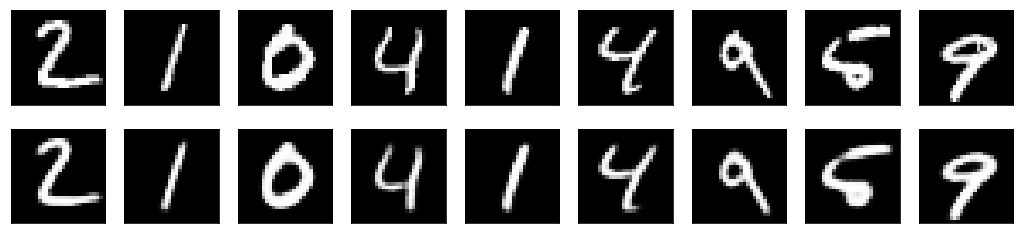

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

ae = Flatten()(encoded)
ae = Dense(49, activation='relu')(ae)
ae = Dense(40, activation='relu')(ae)
ae = Dense(30, activation='relu')(ae)
ae = Dense(20, activation='relu')(ae)
ae = Dense(10, activation='relu')(ae)
ae = Dense(20, activation='relu')(ae)
ae = Dense(30, activation='relu')(ae)
ae = Dense(40, activation='relu')(ae)
ae = Dense(49, activation='relu')(ae)
ae = Reshape((7, 7, 1))(ae)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(ae)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='sgd', loss='mse')
autoencoder.summary()


autoencoder.fit(
    x_train_noisy,
    x_train_noisy,
#     x_train,
    epochs=100,
    batch_size=128
#                 shuffle=True
#                 validation_data=(x_test_noisy, x_test)
               )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 49)                76881     
__________

60000/60000 [==============================] - 5s 75us/step - loss: 0.1065
Epoch 59/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.1065
Epoch 60/100
60000/60000 [==============================] - 4s 75us/step - loss: 0.1065
Epoch 61/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.1065
Epoch 62/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.1065
Epoch 63/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.1065
Epoch 64/100
60000/60000 [==============================] - 4s 75us/step - loss: 0.1065
Epoch 65/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.1065
Epoch 66/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.1065
Epoch 67/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.1064
Epoch 68/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.1064
Epoch 69/100
60000/60000 [===================

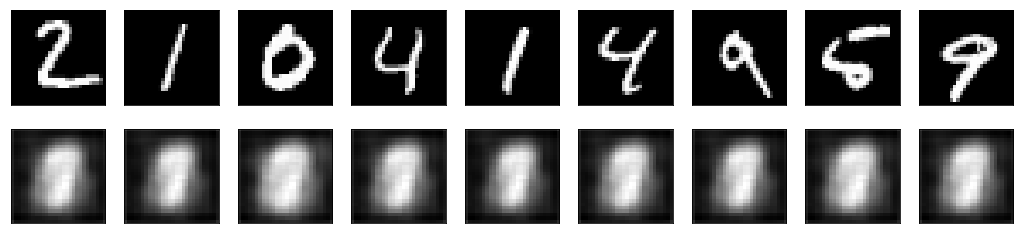

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()